In [147]:
import os
import geopandas as gpd
import sys
wos = 'win' in sys.platform
if wos:
    from osgeo import gdal
    from multiprocess import Pool
    from funcs import get_bounds
else:
    import gdal
    from multiprocessing import Pool
import numpy as np
from numba import jit
from tqdm.autonotebook import tqdm
import math
from shapely import geometry
from pathlib import Path


In [148]:
tile_size_px = [1000,1000] #x,y
tile_oxerlap_px = 150
output_downsample = 0.5
output_folder = r'/media/nick/2TB Working 2/Projects/GeoTIFF_tiler_data/tiles'
geotiff_folder = r'/media/nick/2TB Working 2/Projects/GeoTIFF_tiler_data/VIVID_Landgate_20190910_112102323' if not wos else r'{}'.format(os.getcwd())+r'\\test_imagery\\VIVID_Landgate_20190910_112102323'
input_file_ext = '.tif'
output_compression = 'JPEG'

In [149]:
# you must have v0.8 or up to use use_pygeos
import pkg_resources
pkg_resources.get_distribution('geopandas').version

'0.9.0'

In [150]:
# !conda install -c conda-forge pygeos
gpd.options.use_pygeos = True
print(gpd.options.use_pygeos)

True


In [151]:
%%time
# search folder and all sub folders for 'input_file_ext' files
geo_tiff_list = []
for root, dirs, files in os.walk(geotiff_folder):
    for file in files:
        if file.endswith(input_file_ext):
            geo_tiff_list.append(os.path.join(root, file))
            
len(geo_tiff_list) 

CPU times: user 2.77 ms, sys: 0 ns, total: 2.77 ms
Wall time: 1.39 ms


17

In [152]:
if not wos:
    def get_bounds(tif_path):
    #     open file
        data = gdal.Open(tif_path)
    #     grab bounds
        geoTransform = data.GetGeoTransform()
        left = geoTransform[0]
        top = geoTransform[3]
        right = left + geoTransform[1] * data.RasterXSize
        bottom = top + geoTransform[5] * data.RasterYSize
        geo_tiff_bounds_dict = {'top':top,'left':left,'bottom':bottom,'right':right,'tif_path':tif_path}
        return geo_tiff_bounds_dict

In [153]:
geo_tiff_bounds =get_bounds(geo_tiff_list[0])
geo_tiff_bounds

{'top': -34.27734375,
 'left': 116.455078125,
 'bottom': -34.365234375,
 'right': 116.54296875,
 'tif_path': '/media/nick/2TB Working 2/Projects/GeoTIFF_tiler_data/VIVID_Landgate_20190910_112102323/VIVID_Landgate_20190910_112102323103.tif'}

In [154]:
pool = Pool(3)
with pool:
    list(tqdm(pool.imap(get_bounds,geo_tiff_list[:3]), total=3))

  0%|          | 0/3 [00:00<?, ?it/s]

In [155]:
%%time
for i in geo_tiff_list:
    get_bounds(i)

CPU times: user 1.41 ms, sys: 4.03 ms, total: 5.44 ms
Wall time: 4.48 ms


In [156]:
%%time
# use multiprocessing to extract raster bounds
# interesting when using a small number of geotiffs its is slightly quicker to just run this as a loop
# however once you get over a 100 or so this method is much quicker
with Pool() as pool:
    geo_tiff_bounds = list(tqdm(pool.imap(get_bounds, geo_tiff_list), total=len(geo_tiff_list)))

# make new array with only bounds 
pure_bounds = []
for geo_tif_bounds in geo_tiff_bounds:
    pure_bounds.append([geo_tif_bounds['top'],geo_tif_bounds['left'],geo_tif_bounds['bottom'],geo_tif_bounds['right']])
# convert into numpy array
pure_bounds_np = np.array(pure_bounds)
# # grab max extents
bound_y_max = float(pure_bounds_np[:,0].max()) #top
bound_x_min = float(pure_bounds_np[:,1].min()) #left
bound_y_min = float(pure_bounds_np[:,2].min()) #bottom
bound_x_max = float(pure_bounds_np[:,3].max()) #right

  0%|          | 0/17 [00:00<?, ?it/s]

CPU times: user 23.6 ms, sys: 140 ms, total: 164 ms
Wall time: 279 ms


In [157]:
# open one image to get the pixel size
test_raster = gdal.Open(geo_tiff_list[0])
test_raster_gt =test_raster.GetGeoTransform()
pixel_size_x = test_raster_gt[1]
pixel_size_y = test_raster_gt[5]
print(pixel_size_x,pixel_size_y)

4.487879136029412e-06 -4.487879136029412e-06


In [158]:
# calculate the geographical distance in each direction each tile must be from the last tile
x_move = pixel_size_x*(tile_size_px[0]-tile_oxerlap_px)
y_move = pixel_size_y*(tile_size_px[1]-tile_oxerlap_px)

# calculate the geographical size of each tile
x_tile_size = pixel_size_x*tile_size_px[0]
y_tile_size = pixel_size_y*tile_size_px[1]
print(x_move,y_move)

0.003814697265625 -0.003814697265625


In [159]:
# calculate the number of cols so we can avoid using while loops
number_of_cols = math.ceil(abs((bound_x_max-bound_x_min)/x_move))
number_of_cols

139

In [160]:
# calculate the number of rows so we can avoid using while loops
number_of_rows = math.ceil(abs((bound_y_max-bound_y_min)/y_move))
number_of_rows

93

In [161]:
geo_tiff_bounds[0]['top']

-34.27734375

In [193]:
# will return a list of geotiffs which intersect 
def intersect_tile_with_geotiffs(tile_dict,geo_tiff_bounds):
#     loop over each geotiff
    intersecting_geotiffs = set()
    
    for geo_bounds in geo_tiff_bounds:
#         check is tile top or bottom is inside geotiff
        if (geo_bounds['top'] > tile_dict['top'] > geo_bounds['bottom'] or 
            geo_bounds['top'] > tile_dict['bottom'] > geo_bounds['bottom']):
#         check if left or right are inside a geotiff
            if geo_bounds['right'] > tile_dict['left'] > geo_bounds['left']:
                intersecting_geotiffs.add(geo_bounds['tif_path'])
            if geo_bounds['right'] > tile_dict['right'] > geo_bounds['left']:
                intersecting_geotiffs.add(geo_bounds['tif_path'])
    return intersecting_geotiffs

In [194]:
# will take tile bounds and only export them if they fall within a geotiff
# this is called row by row by pool below
def make_polygons(row):
    tile_polygon_list = []
    tile_top = bound_y_max + y_move*row
    tile_bottom = tile_top + y_tile_size
    tile_left = bound_x_min

    for col in range(0,number_of_cols):
        tile_left = bound_x_min + col*x_move
        tile_right = tile_left + x_tile_size
        tile_dict = {'top':tile_top,'left':tile_left,'bottom':tile_bottom,'right':tile_right}
        tile_list = np.array([tile_top,tile_left,tile_bottom,tile_right])
#         check if valid tile
        intersect = intersect_tile_with_geotiffs(tile_dict,geo_tiff_bounds)
        if len(intersect) > 0:
            polygon = {'geometry':geometry.Polygon([[tile_left, tile_top], [tile_right, tile_top], [tile_right, tile_bottom], [tile_left, tile_bottom]]),
                      'intersect':intersect, 'row':row, 'col':col}
            tile_polygon_list.append(polygon)
    return tile_polygon_list


In [195]:
%%time
tile_polygon_list = []
for row in range(0,number_of_rows):
    tile_polygon_list.append(make_polygons(row))

CPU times: user 114 ms, sys: 21 µs, total: 114 ms
Wall time: 112 ms


In [196]:
%%time
# multiprocess making polygons
with Pool() as pool:
    tile_polygon_list = pool.map(make_polygons, range(0,number_of_rows))

# this is returned as a list of list so it must be flattened
tile_polygon_list = list(np.concatenate(tile_polygon_list).ravel())

CPU times: user 79.7 ms, sys: 160 ms, total: 240 ms
Wall time: 254 ms


In [197]:
tile_polygon_list[0]

{'geometry': <shapely.geometry.polygon.Polygon at 0x7f2dce534710>,
 'intersect': {'/media/nick/2TB Working 2/Projects/GeoTIFF_tiler_data/VIVID_Landgate_20190910_112102323/VIVID_Landgate_20190910_112102323022.tif'},
 'row': 0,
 'col': 0}

In [198]:
%%time
#  convert into geodataframe
polygon_tiles_gpd = gpd.GeoDataFrame(tile_polygon_list,geometry='geometry',crs='EPSG:4326')
del polygon_tiles_gpd['intersect']

CPU times: user 26.7 ms, sys: 39 µs, total: 26.8 ms
Wall time: 26 ms


<AxesSubplot:>

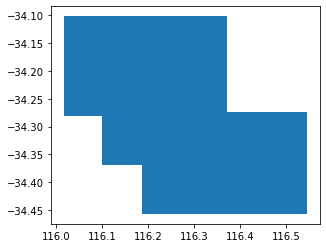

In [199]:
polygon_tiles_gpd.plot()

In [200]:
if not wos:
    polygon_tiles_gpd.to_file("/media/nick/2TB Working 2/Projects/GeoTIFF_tiler_data/output.gpkg", driver="GPKG")
else:
    polygon_tiles_gpd.to_file(r'{}'.format(os.getcwd())+r'\\test_imagery\\VIVID_Landgate_20190910_112102323\\output.gpkg', driver="GPKG")    



In [201]:
tile_polygon_list[46]

{'geometry': <shapely.geometry.polygon.Polygon at 0x7f2dce4d83d0>,
 'intersect': {'/media/nick/2TB Working 2/Projects/GeoTIFF_tiler_data/VIVID_Landgate_20190910_112102323/VIVID_Landgate_20190910_112102323023.tif',
  '/media/nick/2TB Working 2/Projects/GeoTIFF_tiler_data/VIVID_Landgate_20190910_112102323/VIVID_Landgate_20190910_112102323032.tif'},
 'row': 0,
 'col': 46}

In [202]:
%%time
geo_tiff_with_tiles = []
# make a list of which tiles are within which geotiffs
# loop over each geotiff
for geo_tiff in tqdm(geo_tiff_list):
    tiles_inside_geo_tiff = []
#     loop over each tile and check if the geotiff is the the intersect list
    for tile in tile_polygon_list:
        if geo_tiff in tile['intersect']:
#             we count this so we know if the tile will be incomplete or not
            incomplete = len(tile['intersect'])>1
#             build dict with geom the current row and col for naming
            tiles_inside_geo_tiff.append({'geometry':tile['geometry'],'row':tile['row'],'col':tile['col'],'incomplete':incomplete})
    geo_tiff_with_tiles.append([geo_tiff,tiles_inside_geo_tiff])   

  0%|          | 0/17 [00:00<?, ?it/s]

CPU times: user 83.9 ms, sys: 55 µs, total: 83.9 ms
Wall time: 81.4 ms


In [203]:
# geo_tiff_with_tiles[0]

In [215]:
# loop over each geotiff
# for geotiff in tqdm(geo_tiff_with_tiles):
def cut_tiles(geotiff):
#     grab path to to file and open it
    geotiff_open = gdal.Open(geotiff[0])
#     grab the filename and strip the extention
    geo_tiff_filename = os.path.basename(geotiff[0]).replace(input_file_ext,'')
    for tile in geotiff[1]:
        time_geometry = tile['geometry']
#         shapely bounds returns "minx, miny, maxx, maxy" but we need minx, maxy, maxx, miny
        top = list(time_geometry.bounds)[3]
        bottom = list(time_geometry.bounds)[1]
        left = list(time_geometry.bounds)[0]
        right =list(time_geometry.bounds)[2]
        
#         make row folder path
        output_row_folder = os.path.join(output_folder,str(tile['row']))
#       make row folder if nessasary
        Path(output_row_folder).mkdir(parents=True, exist_ok=True)
        export_file_name = str(tile['row'])+'_'+str(tile['col'])+'.tif'
        
#         check if tile is incomplete if so append the getiff name so that it is unique
        if tile['incomplete']:
            append_name = '_'+geo_tiff_filename+'_incomplete.tif'
            export_file_name = export_file_name.replace('.tif',append_name)
#             print('yes')

        export_file_path = os.path.join(output_row_folder,export_file_name)

#     clip the data
#         make a string of tile dims to pass as a command line arg, this is ugly, would like a better option
        tile_clip_string = str(left) +' '+str(top) +' '+str(right) +' '+str(bottom)
    
        translate_options = gdal.TranslateOptions(gdal.ParseCommandLine("-projwin "+tile_clip_string)
                                                 ,creationOptions=['COMPRESS='+output_compression])
        
        tile_clip = gdal.Translate(export_file_path, geotiff_open, options = translate_options)
#     close the tile
        tile_clip = None
#         break

    

In [209]:
# single threaded 
# for tile in tqdm(geo_tiff_with_tiles):
#     cut_tiles(tile)

  0%|          | 0/17 [00:00<?, ?it/s]

TypeError: expected str, bytes or os.PathLike object, not Dataset

In [ ]:
pool = Pool()
with pool:
    list(tqdm(pool.imap(cut_tiles,geo_tiff_with_tiles), total=len(geo_tiff_with_tiles)))

  0%|          | 0/17 [00:00<?, ?it/s]